In [826]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import healpy as hp
import astropy.io.fits as pf
import pandas as pd
import random as rd

## IceCube log likelihood skymap

In [827]:
log_map = hp.fitsfunc.read_map("log10p_maps.fits")

In [742]:
NPIX = hp.nside2npix(len(log_map))

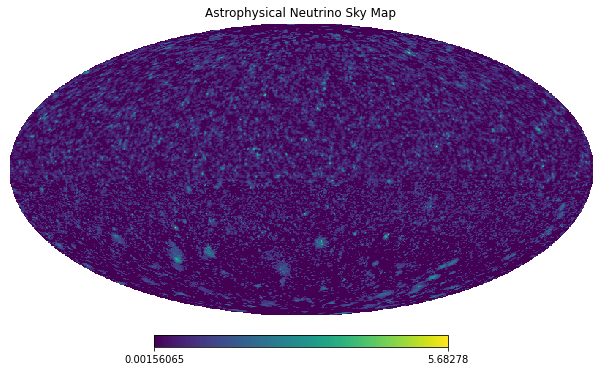

In [766]:
hp.mollview(log_map, title="Astrophysical Neutrino Sky Map")
plt.savefig('/Users/zhangchuanyu/Desktop/skymap.pdf')

In [743]:
data1 = pd.read_csv('rfc_2021d_cat.txt', sep='\\s+')
f1 = pd.DataFrame(data1)
data = f1.to_numpy()

## Function 

In [1006]:
npix = len(log_map)
nside = hp.npix2nside(npix)

def find_source_pix(nside, ra, dec):
    
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    ipix = hp.ang2pix(nside, theta, phi)
    
    return ipix

def find_source_disc_pix(nside, ra, dec, radius):
    
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(np.array(ra))
    radius = np.deg2rad(radius)
    xyz = hp.ang2vec(theta, phi)
    ipix_disc = hp.query_disc(nside, xyz, radius)
    
    return ipix_disc

def Ra(h,m,s): 
    
    return (h*15) + (m/4) + (s/240)

def Dec(D,m,s):
    
    if D>0:
        return D + m/60 + s/3600
    else:
        return -(abs(D)+m/60+s/3600)
    
def find_pix_R(nside,ipix): ## find pixel ra     
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    return ra

def find_pix_d(nside,ipix): ## find pixel dec
    
    
    theta, phi = hp.pix2ang(nside, ipix)
    dec = np.rad2deg(0.5 * np.pi - theta)
     
    return dec    

def likelihood_norm(event,Ice_map): ## Output a set of normalized likelihood 
    
    llh_norm = np.zeros(shape=(len(event),1))
    
    for i in range(len(event)):
        llh_norm[i] = log_map[int(event[:,2][i])] - Ice_map[:,1][np.where(Ice_map[:,0]==event[:,5][i])]
    
    
    
    return llh_norm

def Ra_random(c): ### Generate random ra array 
    
    ra_random = np.zeros(shape=(c,1))
    
    for i in range(c):
        
        ra_random[i] = float(rd.uniform(0,360))
    
    return ra_random    

def Output(data): ### Extract intreseting information from catalog 
    
    npix = len(log_map)
    nside = hp.npix2nside(npix)
    
    dec = np.zeros(shape=(len(data),1))
    ra = np.zeros(shape=(len(data),1))
    pix_index = np.zeros(shape=(len(data),1))
    flux = np.zeros(shape=(len(data),1))
    ra_pix = np.zeros(shape=(len(data),1))
    dec_pix = np.zeros(shape=(len(data),1))
    
    
    for i in range(len(data)):
        dec[i] = Dec(data[:,6][i],data[:,7][i],data[:,8][i])
        ra[i] = Ra(data[:,3][i],data[:,4][i],data[:,5][i])
        pix_index[i] = find_source_pix(nside,ra[i],dec[i])
        flux[i] = data[:,13][i]
        ra_pix[i] = find_pix_R(nside,int(pix_index[i]))
        dec_pix[i] = find_pix_d(nside,int(pix_index[i]))
    
        
    skymap = np.append(ra,dec,axis=1)
    skymap = np.append(skymap,pix_index,axis=1)
    skymap = np.append(skymap,flux,axis=1)
    skymap = np.append(skymap,ra_pix,axis=1)
    skymap = np.append(skymap,dec_pix,axis=1)
    
    return skymap

def shift_ra(data): #### Generate new data after shift RA 
    
    data_shift = np.zeros(shape=(len(data),6))
    Ra_shift = Ra_random(len(data))
    
    for i in range(len(data)):
        data_shift[:,0][i] = Ra_shift[i]
        data_shift[:,1][i] = data[:,1][i]
        data_shift[:,2][i] = find_source_pix(nside,Ra_shift[i],data[:,1][i])
        data_shift[:,3][i] = data[:,3][i]
        data_shift[:,4][i] = find_pix_R(nside,int(data_shift[:,2][i]))
        data_shift[:,5][i] = find_pix_d(nside,int(data_shift[:,2][i]))
    
    return data_shift
    
def p_value(llh_list,ts): ### p-value calculator 
    
    M = len(llh_list)
    
    llh_array = np.array(llh_list)
    
    N = len(llh_array[np.where(llh_array>ts)])
    
    return (N+1)/(M+1)

def sky_map(log_map): ### Output each Dec and Likelihood median 
    
    dec = []
    llh_med = []
    llh_pix = []
    
    map = np.zeros(shape=(len(log_map),3))

    map[:,0] = log_map

    for i in range(len(log_map)):
        map[:,1][i] = find_pix_R(nside,i)
        map[:,2][i] = find_pix_d(nside,i)

    for i in range(len(log_map)-1):
    
        if map[:,2][i]!=map[:,2][i+1]:
            dec.append(map[:,2][i])
        if i == len(log_map)-2:
            dec.append(map[:,2][len(log_map)-1])
            
    for i in range(len(map)-1):
    
        if map[:,2][i]==map[:,2][i+1]:
            llh_pix.append(map[:,0][i])
        
        if map[:,2][i]!=map[:,2][i+1]:
            llh_pix.append(map[:,0][i])
            llh_med.append(np.median(llh_pix))
            llh_pix = []
        if i==len(map)-2:
            llh_pix.append(map[:,0][len(map)-1])
            llh_med.append(np.median(llh_pix))
                
    dec_skymap = np.array([dec])
    llh_medain_sky = np.array([llh_med])        
  
    return np.append(dec_skymap.T,llh_medain_sky.T,axis=1) 
   
def shift_ra1(data): #### Generate new data after shift RA 
    
    data_shift = np.zeros(shape=(len(data),6))
    Ra_shift = Ra_random1(len(data))
    

    data_shift[:,0] = Ra_shift
    data_shift[:,1] = data[:,1]
    data_shift[:,2] = find_source_pix(nside,Ra_shift,data[:,1])
    data_shift[:,3] = data[:,3]
    
    b = data_shift[:,2]
    b = b.astype(int)
    
    data_shift[:,4] = find_pix_R(nside,b)
    data_shift[:,5] = find_pix_d(nside,b)
    
    return data_shift

def Ra_random1(c): ### Generate random ra array 
    
    ra_random = []
    
    for i in range(c):
        
        ra_random.append(float(rd.uniform(0,360)))
    
    return ra_random  

def likelihood_norm1(event,Ice_map): ## Output a set of normalized likelihood 
    
    llh_norm = np.zeros(shape=(len(event),1))
    
   
    llh_norm = log_map[event[:,2]] - Ice_map[:,1][np.where(Ice_map[:,0]==event[:,5])]
    
    
    
    return llh_norm



## Extract Interesting Information from Catalog

In [947]:
data1 = Output(data)
threshold = np.where((data1[:,3]>0.)&(data1[:,1]>-5))
test_sample = data1[threshold]

In [889]:
skymap = sky_map(log_map)

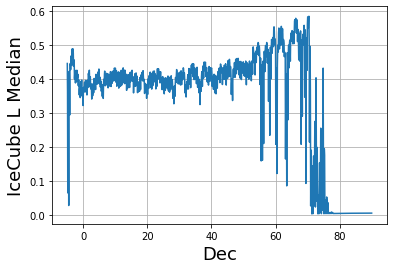

In [890]:
plt.plot(skymap[:,0][np.where(skymap[:,0]>-5)],skymap[:,1][np.where(skymap[:,0]>-5)])
plt.xlabel("Dec",fontsize=18)
plt.ylabel("IceCube L Median",fontsize=18)
plt.grid()
plt.savefig('/Users/zhangchuanyu/Desktop/output.pdf')

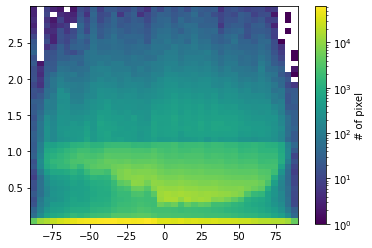

In [844]:
plt.hist2d(map[:,2][np.where(map[:,0]<3)],map[:,0][np.where(map[:,0]<3)],bins=40,norm = colors.LogNorm())
plt.colorbar().set_label("# of pixel")
plt.savefig('/Users/zhangchuanyu/Desktop/L_dec_2dhist.pdf')

In [692]:
llh_norm = likelihood_norm(test_sample,sky_map) 

In [1021]:
MC = 10000
p_val = []

TS = np.median(llh_norm)

flux_selection = np.arange(0.15,2,0.185)

flux_density = np.array([0])
flux_density = np.append(flux_density,flux_selection)


for i in range(len(flux_density)):
    
    selection = np.where((data1[:,3]>flux_density[i])&(data1[:,1]>-5))
    sample = data1[selection]
    
    llh_med_mc = []
    llh_norm = likelihood_norm(sample,skymap)
    TS_value = np.median(llh_norm)
    
    for i in range(MC):
    
        data_sh = shift_ra1(sample)
        llh_norm_shift = likelihood_norm(data_sh,skymap)
        llh_med_mc.append(np.median(llh_norm_shift))
        
    p_val.append(p_value(llh_med_mc,TS_value))    

ValueError: x and y must have same first dimension, but have shapes (11,) and (10,)

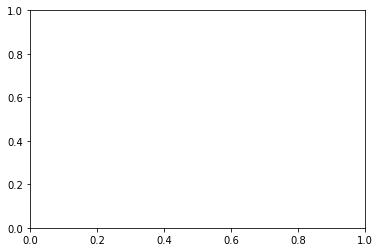

In [909]:
plt.plot(flux_density,[i * 100 for i in p_val])
plt.ylabel("P-Value(%)",fontsize=18)
plt.xlabel("Flux Selection (Jy)",fontsize=18)
plt.grid()
plt.savefig('/Users/zhangchuanyu/Desktop/p_value.pdf')

## Plot Excess Number of AGNs 

In [717]:
L_cut = np.arange(np.min(llh_norm),3,0.05)

excess_number = []
excess_error = []

for i in range(len(L_cut)):
    
    excess_number_mc = []
    
    for j in range(100):
        
        data_sh = shift_ra(test_sample)
        llh_norm_shift = likelihood_norm(data_sh,sky_map)
    
        cut_mc = np.where(llh_norm_shift>L_cut[i])
        cut_data = np.where(llh_norm>L_cut[i])
    
        N = len(llh_norm[cut_data])-len(llh_norm_shift[cut_mc])
        
        excess_number_mc.append(N)
    
    excess_number.append(np.mean(excess_number_mc))
    excess_error.append(np.std(excess_number_mc))    

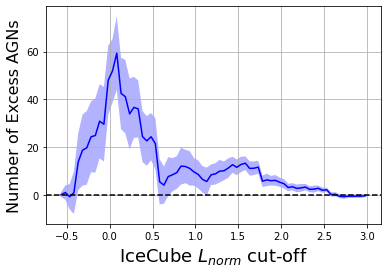

In [843]:
plt.plot(L_cut,excess_number,'-b')
plt.fill_between(L_cut, np.array(excess_number)-np.array(excess_error), np.array(excess_number)+np.array(excess_error),facecolor='blue',alpha=0.3)
plt.xlabel("IceCube $L_{norm}$ cut-off",fontsize=18)
plt.ylabel("Number of Excess AGNs",fontsize=16)
plt.axhline(0.,ls='--',color='black')
plt.grid()
plt.savefig('/Users/zhangchuanyu/Desktop/excess_number.pdf')